# Customer Segmentation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

df = pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv', sep="\t")

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Data Content
## Attributes

### People

- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

### Products

- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

### Promotion

- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

### Place

- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month

# Data Cleaning & Transformation

#### 1. Data Cleaning:

- First, we removed the null data from the dataset. Because the null data only represents 1% of the dataset. 

#### 2. People-Related Features Analysis:

- We transformed the Dt_Customer feature into a Seniority feature and the Year_Birth feature into an Age feature.

- We removed outliers in the Age and Income features, excluding customers over 100 years old and one customer with an income exceeding 600.000.

- For categorical features:

 - We simplified the Education feature to three categories (Phd, Graduation and Basic).
 - The Marital_Status feature was reduced to two categories (Together and Single). Divorced customers were categorized based on the total number of children they have.
 - The Kidhome and Teenhome features were combined into a single feature, where we sum the total chlids.

#### 3. Product Features Analysis:

- We combined all product-related features into a single feature called product_spent, representing the total amount spent by the customer.

#### 4. Promotion-Related Features Analysis:

- We reduced these to two features:
 - One feature representing the total number of deals made with a discount by the customer (NumDealsPurchases).
 - Another feature representing the customer's offer acceptance (Accepted).

#### 5. Place-Related Features Analysis:

- We consolidated the purchase data into a single feature representing all purchases made by the customer (num_purchase), while web visits remained unchanged.


In [2]:
df.info() # Show dataframe info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [3]:
# Null Income Data Percentage 
print('% NULL data: ',round(df[(df['Income'].isnull())].shape[0] * 100 / df.shape[0],2), '%')
print('NULL data: ', df[(df['Income'].isnull())].shape[0])

% NULL data:  1.07 %
NULL data:  24


In [4]:
df = df.dropna() # Delete Null Data

## People Features Analysis

In [5]:
people_columns = ['Age', 'Education', 'Marital_Status', 'Income', 'Kidhome','Teenhome', 'Dt_Customer', 'Recency', 'Complain'] # List of people related features

### Feature Engineering - Seniority & Age

In [6]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format = '%d-%m-%Y') # To datetime Dtype

# seniority relative to the oldest customer enrollment date
df['Dt_Customer'] = (df['Dt_Customer'] - pd.to_datetime('30-07-2012', format = "%d-%m-%Y")) 

df['Dt_Customer'] = df['Dt_Customer'].dt.days

df = df.rename(columns = {'Dt_Customer': 'Seniority'}) # Rename the column

In [7]:
df['Seniority'].info() # Seniority info

<class 'pandas.core.series.Series'>
Index: 2216 entries, 0 to 2239
Series name: Seniority
Non-Null Count  Dtype
--------------  -----
2216 non-null   int64
dtypes: int64(1)
memory usage: 34.6 KB


In [8]:
# Get the approximate age of the customer based on his year birth
df['Year_Birth'] = 2024 - df['Year_Birth'] 
df = df.rename(columns = {'Year_Birth': 'Age'}) # Rename the column

In [9]:
continuous_data = ['Age', 'Income', 'Seniority', 'Recency'] # Continuos people related data

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

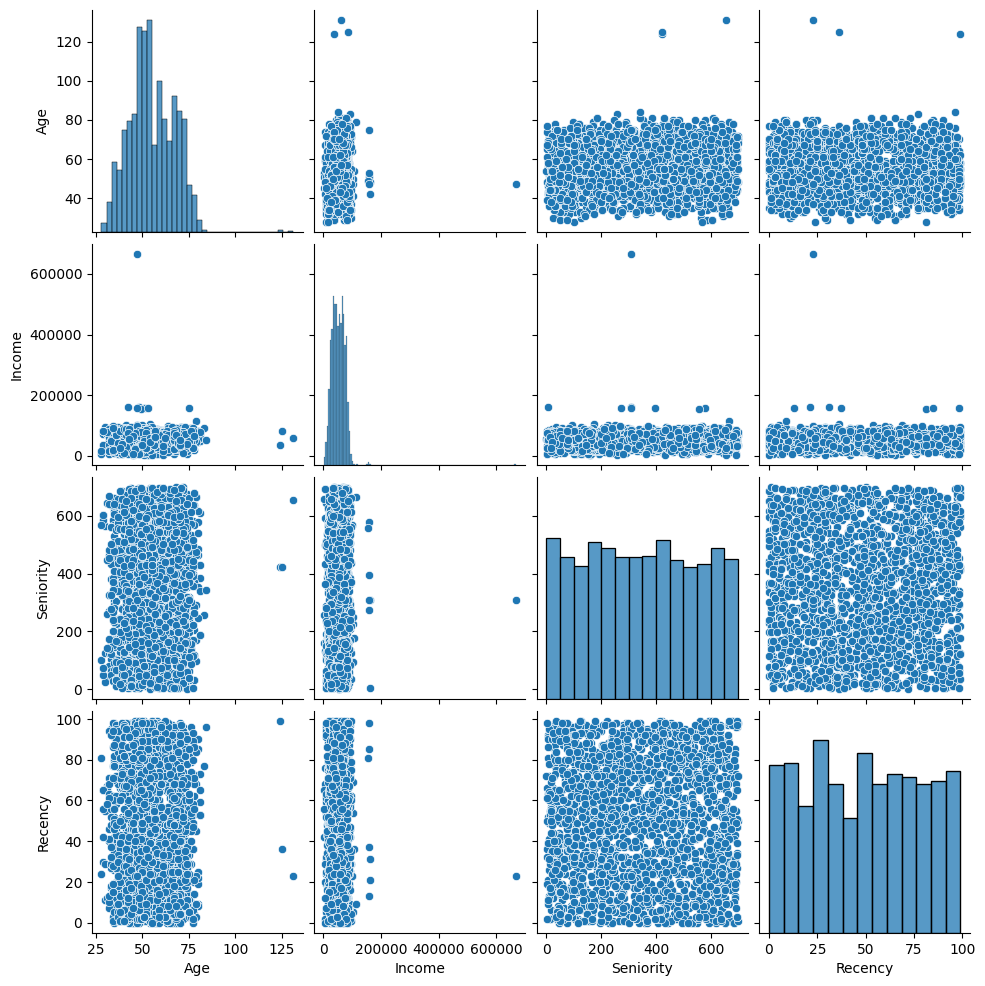

In [10]:
# Create a pairplot with different kinds of plots for the diagonal and off-diagonal elements
sns.pairplot(df[continuous_data])

# Show the plot
plt.show()

### Age & Income Outliers Treatment

In [11]:
df = df[df['Age']  < 100] # Remove age outliers

df = df[df['Income'] <= 600000] # Remove income outliers

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

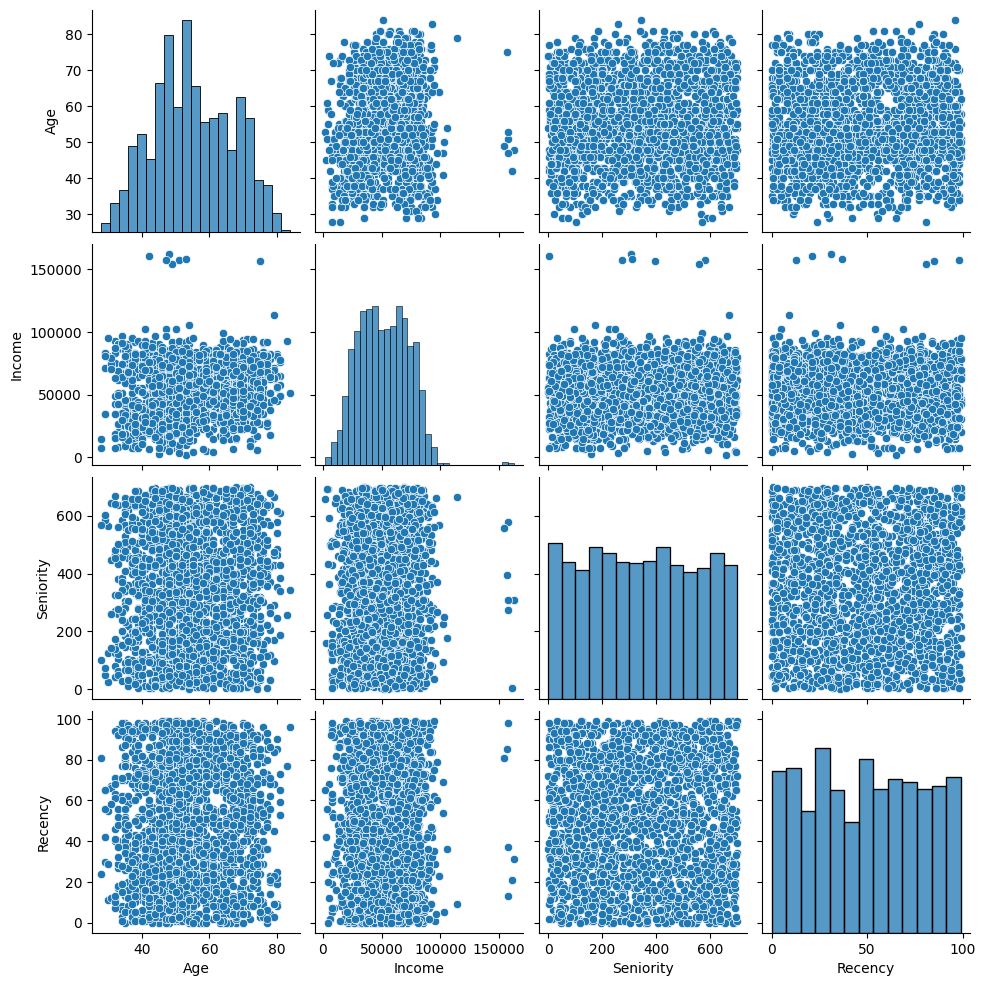

In [12]:
# Create a pairplot with different kinds of plots for the diagonal and off-diagonal elements
sns.pairplot(df[continuous_data])

# Show the plot
plt.show()

### Categorical Feature Transformation

In [13]:
categorical_data = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome'] # List of categorical features

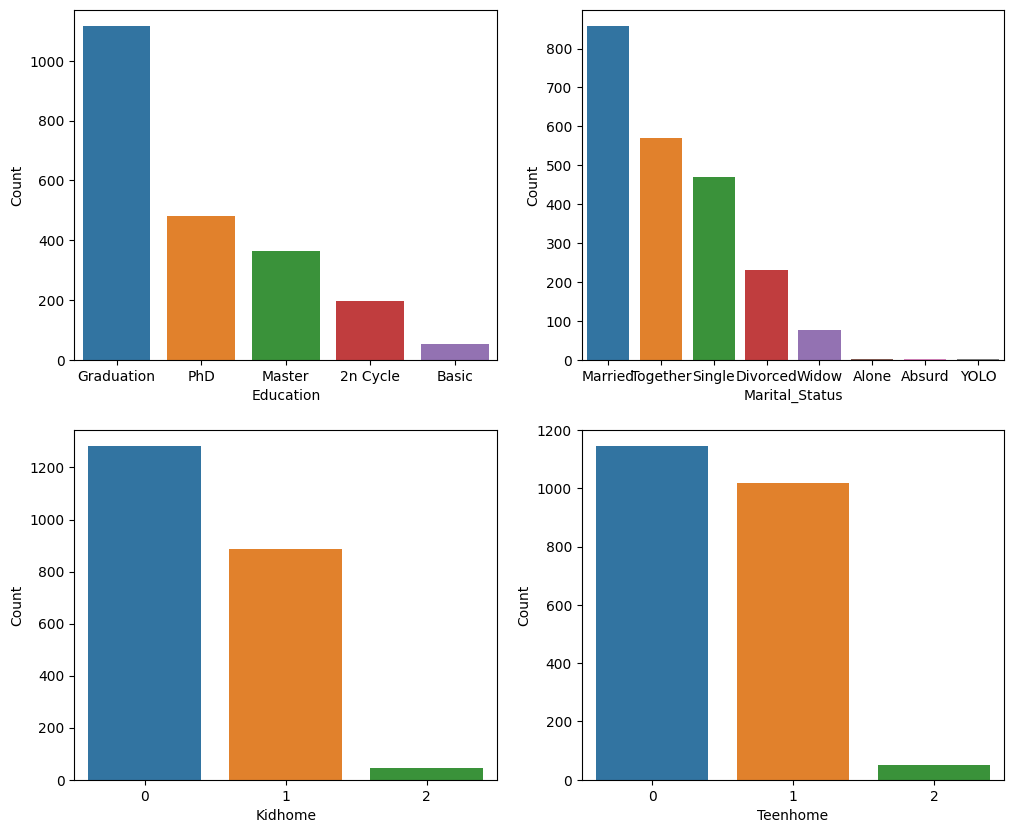

In [14]:
# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for j in range(2):

    for i in range(2):
        
        # Set the feature to plot
        if j == 1:     
            col = categorical_data[j+i+1] 
        else:      
            col = categorical_data[j+i]
        
        # Feature Frequency
        value_counts = df[col].value_counts().reset_index()
        value_counts.columns = [col, 'Count']

        # Create bar plot using seaborn
        sns.barplot(x=col, y='Count', data=value_counts, ax=axs[j, i])
    

#### Education Feature Transformation

In [15]:
# Replace Education categories 

df.loc[(df['Education'] == 'Master') | (df['Education'] == 'PhD'), 'Education'] = 'PhD' # Combine PhD and Master categories
 
df.loc[(df['Education'] == '2n Cycle') | (df['Education'] == 'Basic'), 'Education'] = 'Basic' # Combine 2n Cycle and Basic

#### Kidhome & Teenhome Transformation

In [16]:
df['Child'] = df['Kidhome'] + df['Teenhome'] # Sum Kidhome and Teenhome
 
df.loc[df['Child'] > 0, 'Child'] = 1 # 0 if there is no child, and 1 if there is at least 1

#### Marital Status Transformation

In [17]:
# Replace Marital Status categories

df.loc[(df['Kidhome'] > 0) & (df['Marital_Status'] == 'Divorced'), 'Marital_Status'] = 'Together' # Together if the divorced customer have a child

df.loc[(df['Kidhome'] == 0) & (df['Marital_Status'] == 'Divorced'), 'Marital_Status'] = 'Single' # Single if the divorced customer do not have a child

# Combine the remaining categories
df['Marital_Status']=df['Marital_Status'].replace({'Married':'Together','Absurd':'Single','Widow':'Single','YOLO':'Single','Alone': 'Single'}) 

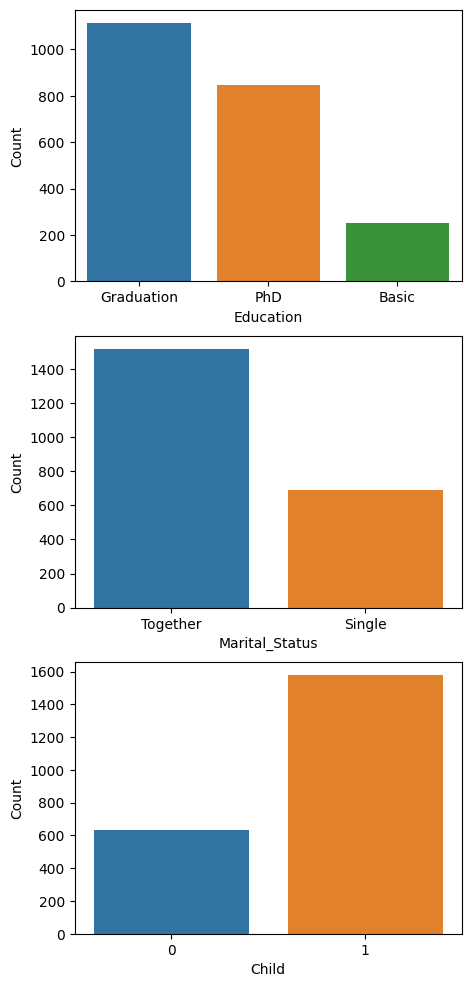

In [18]:
# Create a figure with 2x2 subplots
fig, axs = plt.subplots(3, figsize=(5, 12))

categorical_data = ['Education', 'Marital_Status', 'Child']

for i in range(len(categorical_data)):
        
    col = categorical_data[i] # Set the feature column
    
    # Creata a dataframe to plot the feature data
    value_counts = df[col].value_counts().reset_index()
    value_counts.columns = [col, 'Count']

    # Create bar plot using seaborn
    sns.barplot(x=col, y='Count', data=value_counts, ax=axs[i])

## Products Features Analysis

In [19]:
product_data = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'] # Set product related features

In [20]:
df[product_data].info() # Show info of the product related features

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   MntWines          2212 non-null   int64
 1   MntFruits         2212 non-null   int64
 2   MntMeatProducts   2212 non-null   int64
 3   MntFishProducts   2212 non-null   int64
 4   MntSweetProducts  2212 non-null   int64
 5   MntGoldProds      2212 non-null   int64
dtypes: int64(6)
memory usage: 121.0 KB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

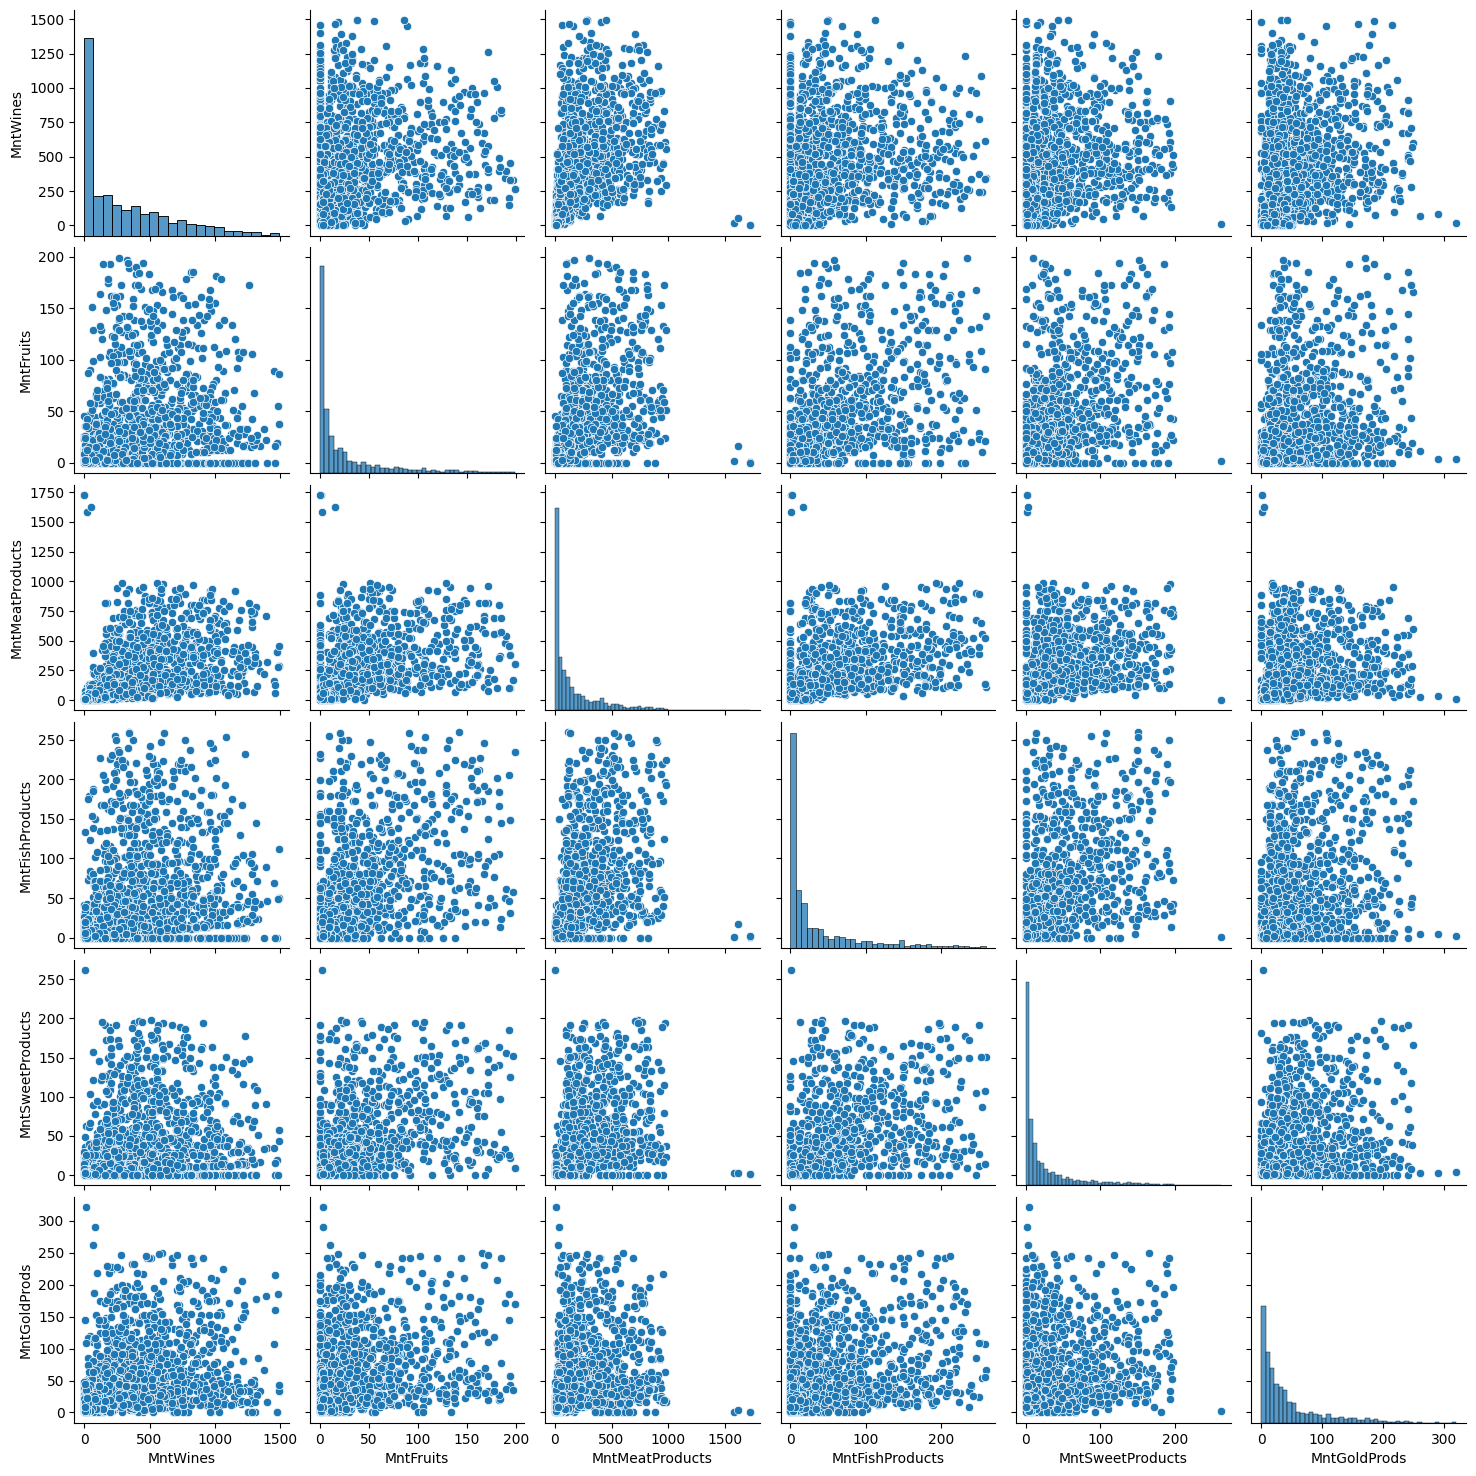

In [21]:
# Create a pairplot with different kinds of plots for the diagonal and off-diagonal elements
sns.pairplot(df[product_data])

# Show the plot
plt.show()

In [22]:
# Set total spent feature
df['product_spent'] = df['MntWines'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntFruits'] + df['MntSweetProducts'] + df['MntGoldProds']

In [23]:
df['product_spent'].describe() # Total spent feature description

count    2212.000000
mean      607.268083
std       602.513364
min         5.000000
25%        69.000000
50%       397.000000
75%      1048.000000
max      2525.000000
Name: product_spent, dtype: float64

## Promotion Features Analysis

In [24]:
promotion_data = ['NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response'] # Set promotion related features

In [25]:
df[promotion_data].describe() # Describe promotion related features

,NumDealsPurchases,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,2.324593,0.064195,0.013562,0.073689,0.074141,0.072785,0.150542
std,1.924507,0.245156,0.115691,0.261323,0.262060,0.259842,0.357683
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Accepted Feature Transformation

In [26]:
# Set a new column based on the offer campaigns 
df['Accepted'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']

df.loc[df['Accepted'] > 0 , 'Accepted'] = 1 # 1 if accepted offer 

In [27]:
df[['NumDealsPurchases', 'Accepted']].describe() # Describe new promotion related features

,NumDealsPurchases,Accepted
count,2212.000000,2212.000000
mean,2.324593,0.273056
std,1.924507,0.445630
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,0.000000
75%,3.000000,1.000000
max,15.000000,1.000000


## Place Features Analysis

In [28]:
place_data = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'] # Set place realated features

In [29]:
df[place_data].describe() # Describe place related features

,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2212.000000,2212.000000,2212.000000,2212.000000
mean,4.088156,2.672242,5.806510,5.321429
std,2.742187,2.927542,3.250939,2.425597
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,3.000000
50%,4.000000,2.000000,5.000000,6.000000
75%,6.000000,4.000000,8.000000,7.000000
max,27.000000,28.000000,13.000000,20.000000


#### Purchase Feature Transformation

In [30]:
# Set new purchase feature
df['num_purchase'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] 

In [31]:
df[['num_purchase', 'NumWebVisitsMonth']].describe() # Describe new place related features

,num_purchase,NumWebVisitsMonth
count,2212.000000,2212.000000
mean,12.566908,5.321429
std,7.205427,2.425597
min,0.000000,0.000000
25%,6.000000,3.000000
50%,12.000000,6.000000
75%,18.250000,7.000000
max,32.000000,20.000000


# Data Preprocessing

### Data Encoding

- We performed label encoding on the Education feature based on a hierarchy of educational levels, with university graduates having the highest rank.
- Additionally, we applied a label encoding to the Marital_Status feature.

In [32]:
# Label encoding education based on  hierarchy
education_ = {'Basic': 0, 'PhD': 2, 'Graduation': 1} 

df['Education_encoded'] = df['Education'].map(education_) # Set new encoded education

In [33]:
# Label encoding Marital Status
marital_ = {'Single': 0, 'Together': 1}

df['Marital_encoded'] = df['Marital_Status'].map(marital_) # Set new encoded marital status

In [34]:
# Set data features
data_features = ['Age', 'Accepted','Income', 'Child', 'Seniority', 'Recency', 
                 'product_spent', 'num_purchase', 'NumWebVisitsMonth',
               'Education_encoded', 'Marital_encoded' ] 

df[data_features].head() 

,Age,Accepted,Income,Child,Seniority,Recency,product_spent,num_purchase,NumWebVisitsMonth,Education_encoded,Marital_encoded
0,67,1,58138.0,0,36,58,1617,22,7,1,0
1,70,0,46344.0,1,586,38,27,4,5,1,0
2,59,0,71613.0,0,387,26,776,20,4,1,1
3,40,0,26646.0,1,560,26,53,6,6,1,1
4,43,0,58293.0,1,538,94,422,14,5,2,1


In [35]:
# Creating a copy of select features
data = df[data_features].copy()

## Feature Scaling

- We scaled the features to ensure that all features contribute equally to the analysis.

In [36]:
from sklearn.preprocessing import StandardScaler

# Scaling data
scaler = StandardScaler()
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data),columns= data.columns )

## Dimensionality Reduction (PCA)

- We performed Principal Component Analysis (PCA) to reduce the number of features, simplifying visualization while retaining the essential information.

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3) # PCA object with 3 components

pca.fit(data_scaled) # Fitting PCA object

# Creating a new dataframe from the PCA transform
data_dim = pd.DataFrame(pca.transform(data_scaled), columns=(["d1","d2", "d3"])) # Set the new feature data after PCA
data_dim.describe().T

,count,mean,std,min,25%,50%,75%,max
d1,2212.0,2.248553e-17,1.875677,-4.716080,-1.631183,-0.354663,1.456001,5.497415
d2,2212.0,-1.284887e-17,1.141237,-3.041213,-0.838081,-0.026828,0.876214,3.742307
d3,2212.0,4.818328e-18,1.092569,-3.001532,-0.780747,-0.062516,0.729531,3.437037


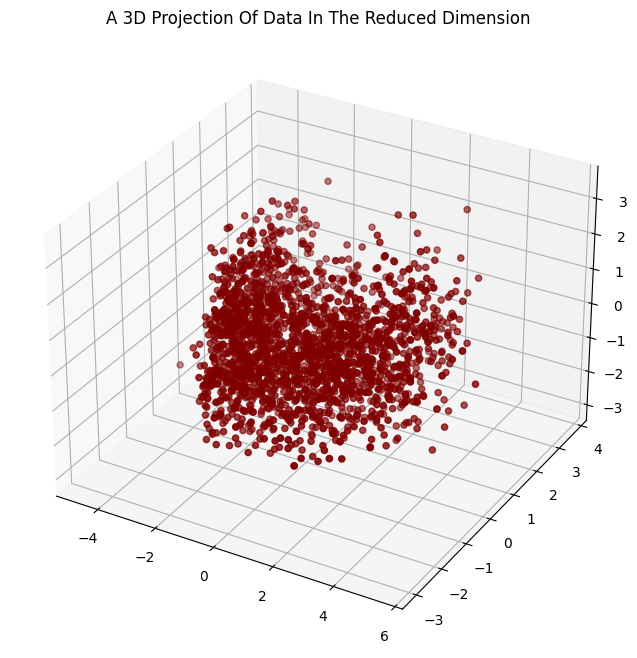

In [38]:
# 3D Projection 
x = data_dim["d1"] # Component d1
y = data_dim["d2"] # Component d2
z = data_dim["d3"] # Component d3

# Create a figure
fig = plt.figure(figsize=(10,8))

# Plot the 3d components
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# K-means Clustering

## Elbow Method

- Using the Elbow Method, we determined that the optimal number of clusters is four.

Elbow Method to determine the number of clusters to be formed:


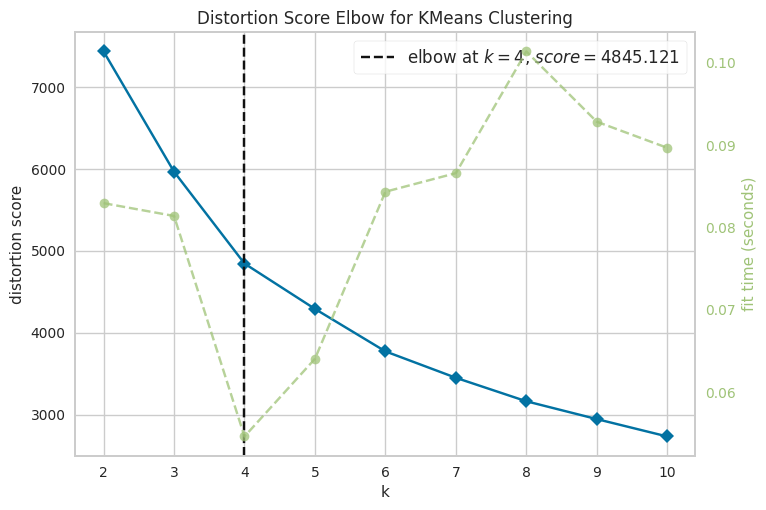

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(n_init=10), k=10)
Elbow_M.fit(data_dim)
Elbow_M.show()

## Model

- We performed a k-means clustering with four clusters.
- Additionally, based on the evaluation metrics, we can conclude that the clusters have decent separation, as indicated by the Silhouette score. Besides, the Calinski-Harabasz Score and Davies-Bouldin Score suggest that the clusters are well defined.

In [40]:
from sklearn.cluster import AgglomerativeClustering

#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(data_dim)

data_dim["Clusters"] = yhat_AC
data["Clusters"] = yhat_AC
data_scaled['Clusters'] = yhat_AC
df['Clusters'] = yhat_AC

In [41]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tabulate import tabulate


# Compute number of customers
num_observations = len(data_dim)

# Separate the features and the cluster labels
X = data_dim.drop('Clusters', axis=1)
clusters = data_dim['Clusters']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

print("Number of Observations", num_observations)
print("Silhouette Score", sil_score)
print("Calinski Harabasz Score", calinski_score)


Number of Observations 2212
Silhouette Score 0.24213456135267847
Calinski Harabasz Score 1055.7843622700655


## Clusters Plot

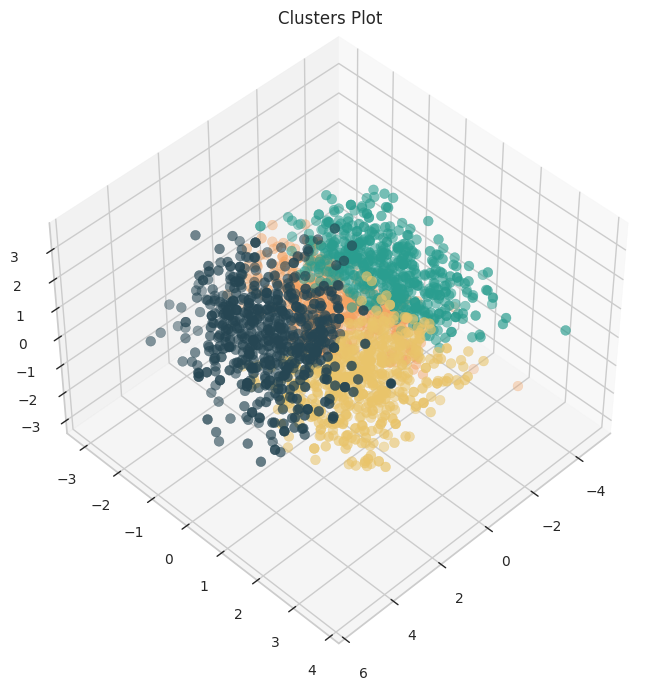

In [42]:
from matplotlib import colors

# Colors
colors = colors.ListedColormap(['#264653', '#2a9d8f', '#e9c46a', '#f4a261'])

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=50, c= data_dim["Clusters"], marker='o',  cmap = colors)
ax.set_title("Clusters Plot")

# Cambiar la perspectiva del gráfico
ax.view_init(elev=45, azim=45)

plt.show()

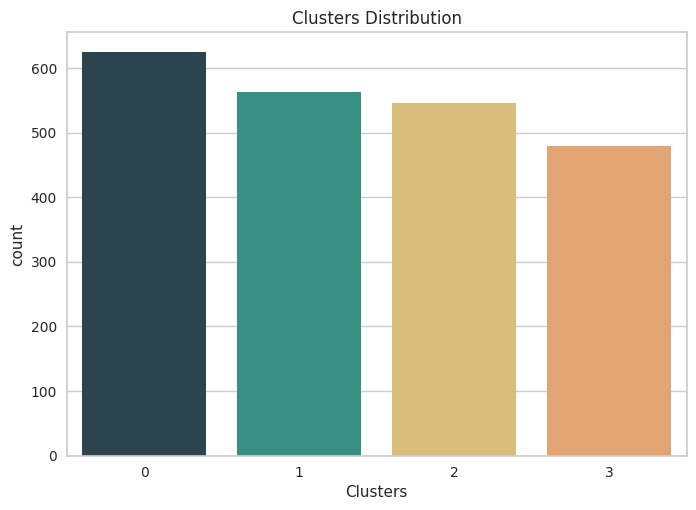

In [43]:
#Plotting countplot of clusters
pal = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261']

pl = sns.countplot(x=data_dim["Clusters"], palette= pal)
pl.set_title("Clusters Distribution")
plt.show()

In [44]:
# Calculate the centroids of each cluster

cluster_centroids = data_scaled.groupby('Clusters').mean()

## Clusters Analysis

In [45]:
labels = np.array(cluster_centroids.columns)

num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]


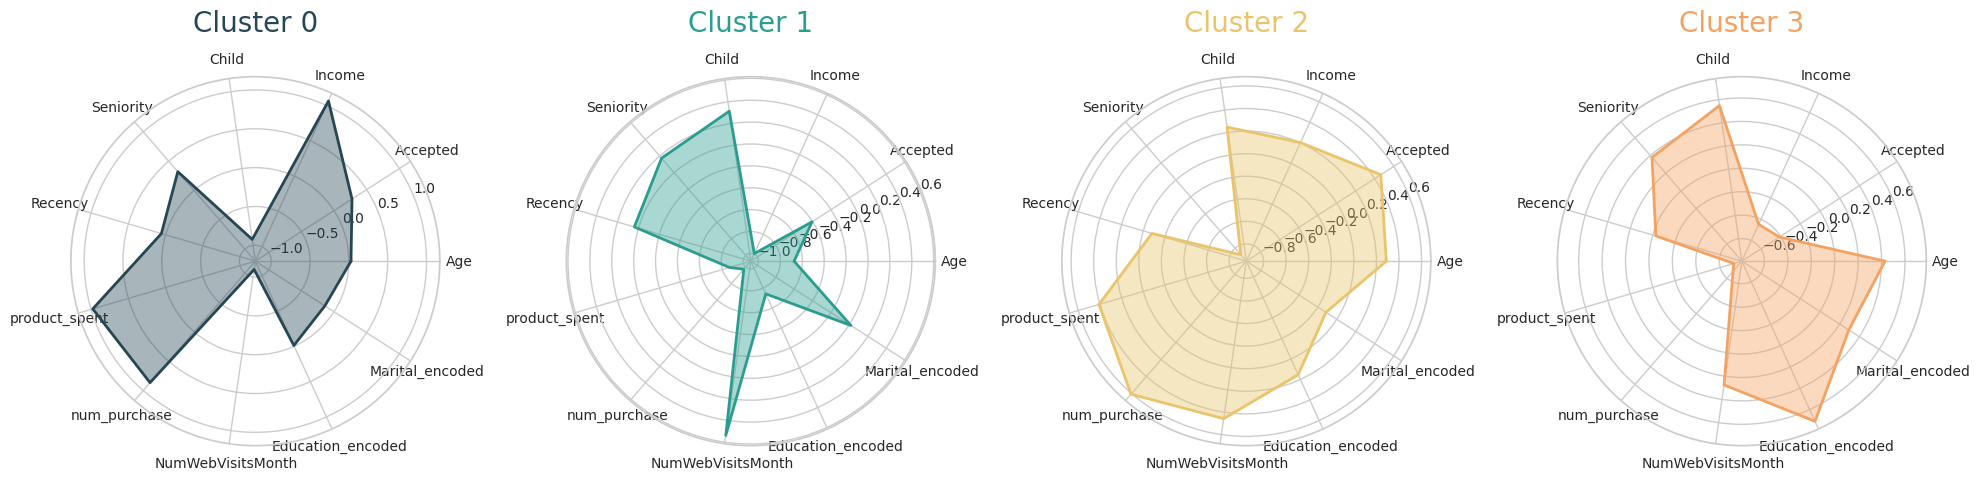

In [46]:
# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=4)

clusters = np.sort(data_scaled['Clusters'].unique())

for i in range(len(clusters)):

    # Create radar chart for each cluster
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, pal[i], i)
  
    # Add input data
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])

# Display the plot
plt.tight_layout()
plt.show()

* ### Cluster 0: Relatively young customers, with a high income.
    * #### The customers of this clusters show a high income, with hig product spending and high number of purchase.
    * #### They have a tendency of be single and have no child.
    * #### They do not use the web site and present a moderate seniority.
    * #### They show a moderate acceptance of the campaing offers.


- ### Cluster 1: Young fathers with low Income.
    - #### The customers in these clusters show low product spending and high web visits, which could indicate that they are interested in purchasing but may not have the financial means to do so.
    - #### They tend to have children and be in a relationship.
    - #### The customers of this clusters are relatively young .



- ### Cluster 2: Old Fathers with a moderate income and high product spent.
    - #### The customers of this cluster show a moderate income, but a high product spending and purchasing.
    - #### They tend to visit the web and accept the campaing offers.
    - #### These customers exhibit a low seniority, wich means that they are relatively new customers.


- ### Cluster 3: Old Fathers with high seniority, but low income.
    - #### The customers of this clusters show a low income and high seniority.
    - #### These customer tend to visit the web, but show a low product spending and purchasing. 
    - #### Their average education is a PhD or a Master.
    - #### They tend to have a Child and be in a relationship.

# Conclusion

### Based on the radar chart, we can observe that the customers in clusters 0 and 2 are the most valuable. These customers exhibit high spending and frequent purchasing, making them the primary target audience. In particular, customers in cluster 0 show a moderate acceptance of campaign offers, whereas those in cluster 2 are more likely to accept campaign offers.
### On the other hand, customers in clusters 1 and 3 tend to visit the website frequently but they do not make any purchases, likely due to their lower income compared to the other two clusters. To increase their spending, we need more attractive campaign offers.